# Insult Detection Model

### Project by 
#### Chirag Khurana, Pallavi S. Rawat, Shubham Goyal

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import auc, roc_auc_score, roc_curve

import pandas as pd
import numpy as np
import spacy

## Importing Data Set 

In [2]:
# Unprocessed Data
full_df = pd.read_csv('../data/train.csv')
verify_df = pd.read_csv('../data/impermium_verification_labels.csv')
data = full_df.append(verify_df)
data.Comment = [x[1: -1] for x in data.Comment]

# Processed Data
full_df = pd.read_csv('../data/processed/train.csv')
verify_df = pd.read_csv('../data/processed/impermium_verification_labels.csv')
pdata = full_df.append(verify_df)

In [3]:
pdata.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""you fuck you are dad."""
1,0,20120528192215Z,"""i really do not understand you are point. it ..."
2,0,NaN,"""a majority of canadians can and has been wron..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""c b xu bi t 2011 c ho kh ? c ng d ng cu chi n..."


#### Trying cleaning stop words

In [4]:
nlp = spacy.load('en')
def sanitize_wo_stopwords(sentence):
    doc = nlp(sentence)
    s = []
    for token in doc:
#         print(token.dep_)
        if str(token.pos_) != 'SPACE' and not token.is_stop:
            s.append(token.text)
    return ' '.join(s)

def sanitize_with_words(sentence):
    doc = nlp(sentence)
    s = []
    for token in doc:
#         print(token.dep_)
        if str(token.pos_) != 'SPACE' and not token.is_stop:
            s.append(token.text)
    return ' '.join(s)


def sanitize_with_lemma(sentence):
    doc = nlp(sentence)
    s = []
    for token in doc:
#         print(token.dep_)
        if str(token.pos_) != 'SPACE':
            s.append(token.lemma_)
    return ' '.join(s)

In [5]:
pdata.Comment = [sanitize_wo_stopwords(x[1: -1]) for x in pdata.Comment]
# full_df.Comment = [sanitize_with_words(x[1: -1]) for x in full_df.Comment]
# full_df.Comment = [sanitize_with_lemma(x[1: -1]) for x in full_df.Comment]


# pdata.Comment = [x[1: -1] for x in pdata.Comment]

## Understanding Data 

In [64]:
data.describe()

,Insult,id
count,6182.000000,2235.000000
mean,0.343902,1118.000000
std,0.475047,645.333247
min,0.000000,1.000000
25%,0.000000,559.500000
50%,0.000000,1118.000000
75%,1.000000,1676.500000
max,1.000000,2235.000000


In [65]:
data.head()

,Comment,Date,Insult,Usage,id
0,You fuck your dad.,20120618192155Z,1,NaN,NaN
1,i really don't understand your point.\xa0 It s...,20120528192215Z,0,NaN,NaN
2,A\\xc2\\xa0majority of Canadians can and has b...,NaN,0,NaN,NaN
3,listen if you dont wanna get married to a man ...,NaN,0,NaN,NaN
4,C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...,20120619094753Z,0,NaN,NaN


In [66]:
pdata.head()

,Insult,Date,Comment
0,1,20120618192155Z,fuck dad .
1,0,20120528192215Z,understand point . mixing apples oranges .
2,0,NaN,majority canadians wrong . supportive idea pro...
3,0,NaN,listen nt wanna married man women nt . bother ...
4,0,20120619094753Z,c b xu bi t 2011 c ho kh ? c ng d ng cu chi nh...


In [6]:
pdata_ni = pdata.query('Insult == 0')
pdata_i = pdata.query('Insult == 1')
pdata_ni.shape, pdata_i.shape

((4056, 3), (2126, 3))

In [7]:
ptrain_ni, ptest_ni = train_test_split(pdata_ni, test_size=0.6)
print(ptrain_ni.shape, ptest_ni.shape)

ptrain_i, ptest_i = train_test_split(pdata_i, test_size=0.2)
print(ptrain_i.shape, ptest_i.shape)

(1622, 3) (2434, 3)
(1700, 3) (426, 3)


### Splitting Dataset

In [8]:
# train, test = train_test_split(data, test_size=0.2)
# ptrain, ptest = train_test_split(pdata, test_size=0.2)
ptrain = ptrain_i.append(ptrain_ni)
ptest = ptest_i.append(ptest_ni)

## Feature Extraction

#### TFIDF as feature

In [70]:
tfidf_w = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', use_idf=False, max_features=50000) 
tfidf_c = TfidfVectorizer(ngram_range=(3, 10), analyzer='char', use_idf=False, max_features=100000)

In [71]:
ptrain_data_w = tfidf_w.fit_transform(ptrain.Comment)
ptrain_data_c = tfidf_c.fit_transform(ptrain.Comment)

ptrain_data_w.shape, ptrain_data_c.shape

((3322, 50000), (3322, 100000))

## Classification of Insult

#### Helper Functions

In [15]:
def normalize_mat(mat):
    m = []
    for i, row in enumerate(mat):
        m.append([float(x / sum(row)) for x in row])
    return np.array(m)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Multinomial NaiveBayes

In [73]:
insult_nb_w = MultinomialNB(alpha=0.01)
insult_nb_w.fit(ptrain_data_w, ptrain.Insult)

insult_nb_c = MultinomialNB(alpha=0.01)
insult_nb_c.fit(ptrain_data_c, ptrain.Insult)

ptest_data_w = tfidf_w.transform(ptest.Comment)
ptest_data_c = tfidf_c.transform(ptest.Comment)

predicted_nb_w = insult_nb_w.predict(ptest_data_w)
predicted_nb_c = insult_nb_c.predict(ptest_data_c)
print(np.mean(predicted_nb_w == ptest.Insult), np.mean(predicted_nb_c == ptest.Insult))
predicted_nb_w_prob = insult_nb_w.predict_proba(ptest_data_w)
predicted_nb_c_prob = insult_nb_c.predict_proba(ptest_data_c)

0.66013986014 0.717132867133


#### Confusion Matrix for NB Classifier on Word - N-grams

Normalized confusion matrix


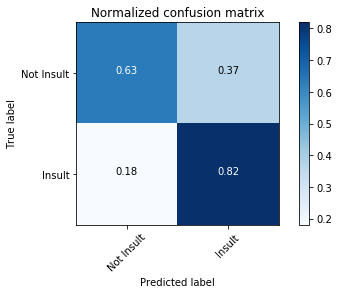

In [74]:
# Compute confusion matrix
cnf_matrix_w = confusion_matrix(ptest.Insult, predicted_nb_w)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_w, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_w, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confusion Matrix for NB Classifier on Character - N-grams

Normalized confusion matrix


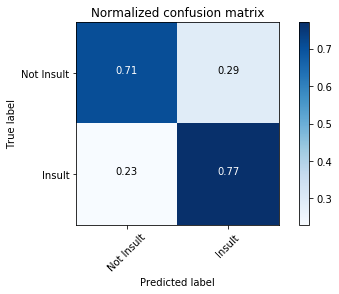

In [75]:
# Compute confusion matrix
cnf_matrix_c = confusion_matrix(ptest.Insult, predicted_nb_c)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### LinearSVC

In [76]:
insult_svm_w = LinearSVC()
insult_svm_w.fit(ptrain_data_w, ptrain.Insult)

insult_svm_c = LinearSVC()
insult_svm_c.fit(ptrain_data_c, ptrain.Insult)

ptest_data_w = tfidf_w.transform(ptest.Comment)
ptest_data_c = tfidf_c.transform(ptest.Comment)

predicted_svm_w = insult_svm_w.predict(ptest_data_w)
predicted_svm_c = insult_svm_c.predict(ptest_data_c)
np.mean(predicted_svm_w == ptest.Insult), np.mean(predicted_svm_c == ptest.Insult)

(0.72692307692307689, 0.7503496503496504)

#### Confusion Matrix for SVM Classifier on Word - N-grams

Normalized confusion matrix


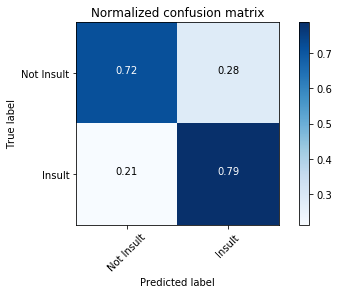

In [77]:
# Compute confusion matrix
cnf_matrix_w = confusion_matrix(ptest.Insult, predicted_svm_w)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_w, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_w, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confusion Matrix for SVM Classifier on Character - N-grams

Normalized confusion matrix


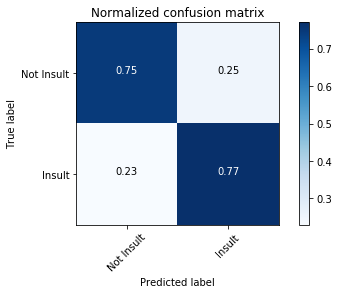

In [78]:
# Compute confusion matrix
cnf_matrix_c = confusion_matrix(ptest.Insult, predicted_svm_c)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Logistic Regression

In [81]:
insult_lr_w = LogisticRegression()
insult_lr_w.fit(ptrain_data_w, ptrain.Insult)

insult_lr_c = LogisticRegression()
insult_lr_c.fit(ptrain_data_c, ptrain.Insult)

ptest_data_w = tfidf_w.transform(ptest.Comment)
ptest_data_c = tfidf_c.transform(ptest.Comment)

predicted_lr_w = insult_lr_w.predict(ptest_data_w)
predicted_lr_c = insult_lr_c.predict(ptest_data_c)
print(np.mean(predicted_lr_w == ptest.Insult), np.mean(predicted_lr_c == ptest.Insult))
predicted_lr_w_prob = insult_lr_w.predict_proba(ptest_data_w)
predicted_lr_c_prob = insult_lr_c.predict_proba(ptest_data_c)

0.742307692308 0.769230769231


#### Confusion Matrix for Logistic Regression Classifier on Word - N-grams

Normalized confusion matrix


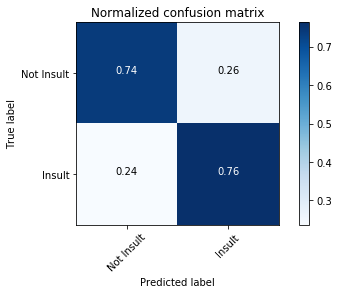

In [82]:
# Compute confusion matrix
cnf_matrix_w = confusion_matrix(ptest.Insult, predicted_lr_w)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_w, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_w, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confusion Matrix for Logistic Regression Classifier on Character - N-grams

Normalized confusion matrix


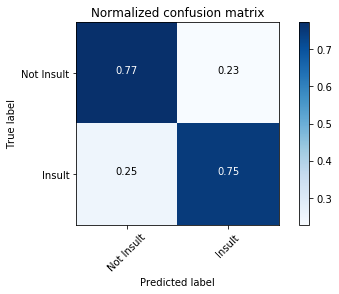

In [83]:
# Compute confusion matrix
cnf_matrix_c = confusion_matrix(ptest.Insult, predicted_lr_c)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

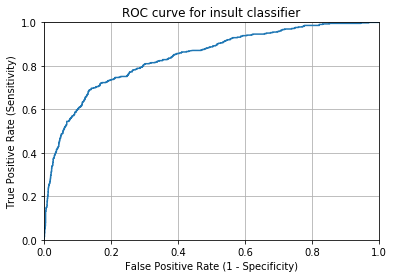

In [85]:
fpr, tpr, thresholds = roc_curve(ptest.Insult, predicted_lr_c_prob[:, 1:])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for insult classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

In [84]:
print(roc_auc_score(ptest.Insult, predicted_lr_c_prob[:, 1:]), roc_auc_score(ptest.Insult, predicted_lr_w_prob[:, 1:]))

0.840551112757 0.826209103429


## Ensemble

In [23]:
from sklearn.pipeline import Pipeline
pipe_svm_w = Pipeline(
    [
        ('tfidf_w', TfidfVectorizer(ngram_range=(1,3), use_idf=False, analyzer='word', max_features=5000)),
        ('svm_w', LinearSVC()),
    ]
)
pipe_svm_c = Pipeline(
    [
        ('tfidf_c', TfidfVectorizer(ngram_range=(3,10), use_idf=False, analyzer='char', max_features=10000)),
        ('svm_c', LinearSVC()),
    ]
)

pipe_lr_w =   Pipeline(
    [
        ('tfidf_w', TfidfVectorizer(ngram_range=(1,3), use_idf=False, analyzer='word', max_features=5000)),
        ('lr_w', LogisticRegression()),
    ]
)
pipe_lr_c =   Pipeline(
    [
        ('tfidf_c', TfidfVectorizer(ngram_range=(3,10), use_idf=False, analyzer='char', max_features=10000)),
        ('lr_c', LogisticRegression()),
    ]
)


In [24]:
pipe_svm_w.fit(ptrain.Comment, ptrain.Insult)
pipe_svm_c.fit(ptrain.Comment, ptrain.Insult)
pipe_lr_w.fit(ptrain.Comment, ptrain.Insult)
pipe_lr_c.fit(ptrain.Comment, ptrain.Insult)
pipe_svm_w.score(ptest.Comment, ptest.Insult), pipe_lr_c.score(ptest.Comment, ptest.Insult), pipe_lr_c.score(ptest.Comment, ptest.Insult)

MemoryError: 

In [22]:
vote_clf = VotingClassifier(
    estimators=[
#         ('svm_w', pipe_svm_w),
#         ('svm_c', pipe_svm_c),
        ('lr_w', pipe_lr_w),
        ('lr_c', pipe_lr_c),
    ],
#     voting='soft'
)

vote_clf.fit(ptrain.Comment, ptrain.Insult)
pred = vote_clf.predict(ptest.Comment)
print(np.mean(pred == ptest.Insult))
# pred_prob = vote_clf.predict_proba(ptest.Comment)

MemoryError: 

In [ ]:
fpr, tpr, thresholds = roc_curve(ptest.Insult, predicted_lr_c_prob[:, 1:])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for insult classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

Normalized confusion matrix


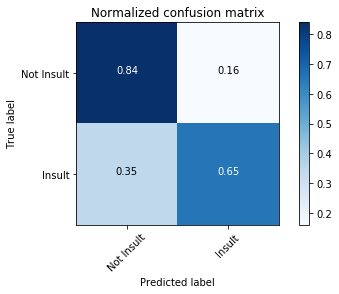

In [16]:
# Compute confusion matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_c, classes=['Not Insult', 'Insult'],
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_vote, classes=['Not Insult', 'Insult'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()